In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
from pysal.model import mgwr
# from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import matplotlib

import libpysal
import spreg
import esda

import os

In [2]:
df = pd.read_csv("../02 Data/modeling.csv")
gdf = gpd.read_file("../02 Data/shp/merge_all.shp")

In [3]:
df['Geography'] = df['Geography'].astype(str)
merge = pd.merge(gdf, df, left_on="geoid20", right_on="Geography", how="right")

len(merge)

286

In [4]:
x_1 = merge[[
        'Geography',
         'his_num_311_per_property',
         'neighbor_his_num_per_property',
         'snow_depth',
         'percent_below_poverty',
         'percent_civilian_unemployed',
         'per_capita_income',
         'percent_no_highschool',
         'percent_65older',
         'percent_17younger',
         'percent_household_disability',
         'percent_single_parent_household',
         'percent_minority',
         'percent_notwell_english',
         'percent_singleunits',
         'percent_multiunit',
         'percent_mobile_homes',
         'percent_owneroccupiedunit',
         'percent_crowding',
         'percent_group_quarters',
         'median_year_properties_built',
         'median_value_properties_built',
         'percent_no_vehicle',
         '311_index_per_property'
        ]]

x_1 = x_1.set_index("Geography")
y = x_1.pop('311_index_per_property')

# Standardization function
def standarize_data(data, stats):
    return (data - stats['mean'])/ stats['std']

x_1_stats = x_1.describe().transpose()
x_2 = standarize_data(x_1,x_1_stats)

merge["X"] = pd.to_numeric(merge['X']) 
merge["Y"] = pd.to_numeric(merge['Y']) 
lng_lat_coords = np.column_stack([merge["X"], merge["Y"]])

In [5]:
selector = mgwr.sel_bw.Sel_BW(lng_lat_coords, 
                            np.asarray(y).reshape(-1,1), 
                            np.asarray(x_2), 
                            spherical=False)

bw = selector.search(criterion='AICc') # golden section search; AIC; number of nearest neighbor

gwr_model = mgwr.gwr.GWR(lng_lat_coords, 
                       np.asarray(y).reshape(-1,1), 
                       np.asarray(x_2), 
                       bw)

gwr_results = gwr_model.fit()

In [6]:
bw

285.0

In [7]:
gwr_results.R2

0.575225498220363

In [8]:
#obtain prediction
y_pred = gwr_results.predy

#calculate RMSE
rmse = mean_squared_error(y , y_pred, squared=False)
print("RMSE of GWR: ", rmse)

RMSE of GWR:  3.4679190537057094


C:\Users\ryanz\anaconda3\envs\blizzard\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [9]:
gwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                 286
Number of covariates:                                                    23

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                           3803.309
Log-likelihood:                                                    -775.848
AIC:                                                               1597.696
AICc:                                                              1604.294
BIC:                                                               2315.783
R2:                                                                   0.530
Adj. R2:                                                              0.491

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

In [10]:
final_columns = ['historical 311 requests pp', 'nearby-CBG historical 311 requests pp', 'snow depth', 
                 '% poverty', '% unemployed',
                 'income', '% < highschool', '% age ≥ 65', 
                 '% age < 18', '% disability', 
                 '% single parent', '% minority', 
                 '% not well English', '% single-unit structure',
                '% multi-unit structure', '% mobile homes',
                '% owner-occupied housing units', '% crowding housing units',
                '% in group quarters', 'median year built', 'median property value', '% no vehicle available']

In [11]:
feature_list = final_columns
col_nam = ['const']+feature_list # const is like constant

#obtain coefficients from the GWR
df_coef = pd.DataFrame(
    data=gwr_results.params,
    columns=col_nam,
    index=x_2.index
) 

In [12]:
df_coef

,const,historical 311 requests pp,nearby-CBG historical 311 requests pp,snow depth,% poverty,% unemployed,income,% < highschool,% age ≥ 65,% age < 18,...,% not well English,% single-unit structure,% multi-unit structure,% mobile homes,% owner-occupied housing units,% crowding housing units,% in group quarters,median year built,median property value,% no vehicle available
Geography,,,,,,,,,,,,,,,,,,,,,
360290001101,10.926050,3.492584,0.455458,0.728791,-0.531610,-0.153514,-0.507665,0.127176,-0.068674,-0.850331,...,-0.236065,0.935195,-0.524796,0.048915,-1.081676,0.175263,-0.038137,0.947633,0.049081,-0.073737
360290001102,10.938551,3.491261,0.444194,0.710055,-0.531258,-0.143838,-0.506070,0.131126,-0.070370,-0.843469,...,-0.234167,0.948765,-0.520449,0.047376,-1.083120,0.180556,-0.024362,0.952945,0.048815,-0.072815
360290001103,10.840969,3.419428,0.480415,0.793412,-0.598640,-0.128308,-0.557350,0.129137,-0.095788,-0.897123,...,-0.193389,0.963047,-0.483699,0.070100,-1.029197,0.156979,-0.023405,0.912072,0.108093,0.001301
360290002001,10.975162,3.490925,0.409940,0.657812,-0.528556,-0.116287,-0.495839,0.140578,-0.075023,-0.818671,...,-0.229584,0.984425,-0.507447,0.042268,-1.085655,0.195967,0.013362,0.968804,0.046597,-0.069749
360290002002,10.960426,3.492619,0.425270,0.679898,-0.528145,-0.129518,-0.499810,0.136285,-0.072160,-0.829439,...,-0.232766,0.967397,-0.514572,0.044177,-1.085941,0.189267,-0.003944,0.962305,0.046272,-0.073175
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360290171001,10.977225,3.080429,0.013303,1.149258,-0.443122,0.150850,-0.343987,-0.395446,-0.229591,-0.605608,...,-0.072480,1.089416,-0.113840,0.073125,-0.807641,0.131487,0.195186,0.727675,0.315240,0.333833
360290171002,10.989932,3.116979,0.012370,1.106492,-0.451515,0.156177,-0.328496,-0.361976,-0.227119,-0.596945,...,-0.079848,1.097199,-0.128575,0.072054,-0.824415,0.139507,0.198802,0.757956,0.305686,0.314824
360290171003,10.980812,3.110102,0.022755,1.096248,-0.468569,0.152518,-0.346171,-0.350293,-0.232375,-0.609917,...,-0.072122,1.105477,-0.129207,0.076868,-0.819911,0.136451,0.195114,0.758031,0.308180,0.327015


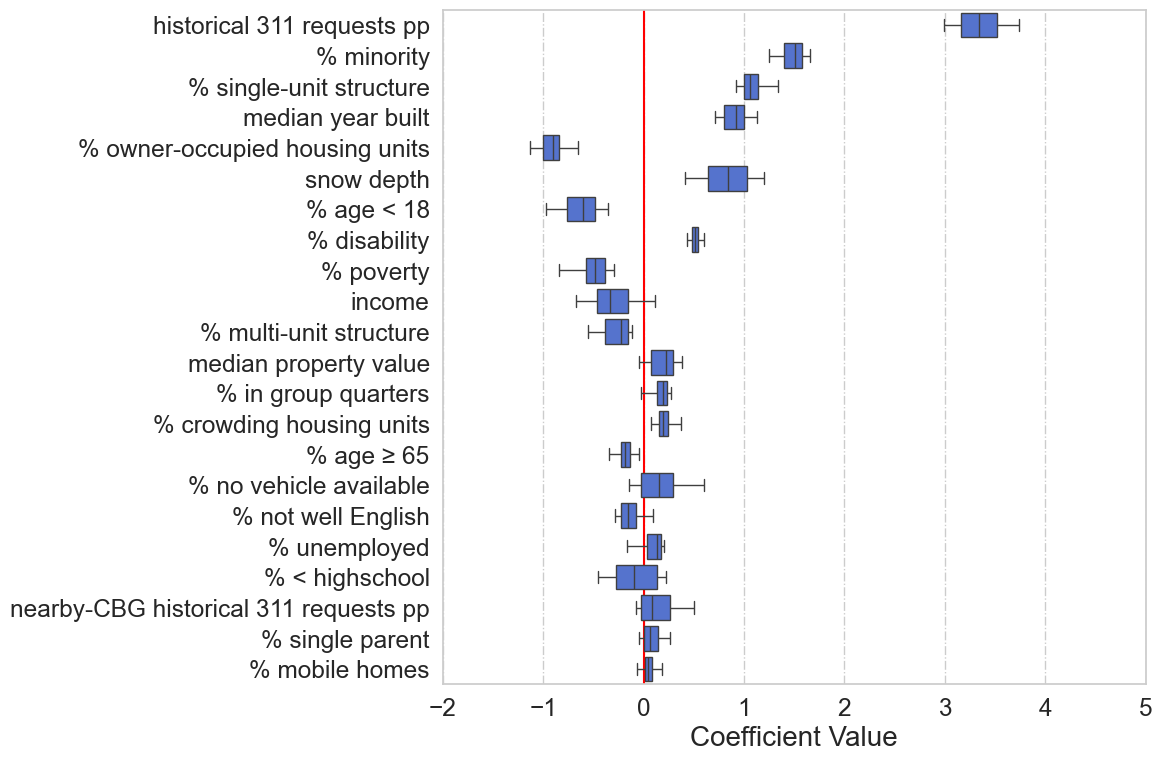

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 28}

matplotlib.rc('font', **font)

plt.figure(figsize=(12,8))
sns.set_theme(style="whitegrid",font_scale = 1.6)

df_complete_feaimp_box = df_coef.copy()
del df_complete_feaimp_box['const']
index_sort = df_complete_feaimp_box.median().abs().sort_values(ascending=False).index
df_complete_feaimp_box = df_complete_feaimp_box[index_sort]

ax = sns.boxplot(data=df_complete_feaimp_box, orient='h', showfliers = False, color = "royalblue")
plt.axvline(x=0, color='red', linestyle='-', linewidth=1.5, zorder=1)
plt.xlabel('Coefficient Value', fontsize=20)
plt.ylabel('')
plt.grid(axis = 'x', linestyle='-.')
plt.xlim(-2, 5)
plt.tight_layout()
# plt.savefig("../03 Figures/GWR_Coefficient_Value.png",dpi=300)

### T Values

In [17]:
gwr_tvalues = gwr_results.filter_tvals()
gwr_tvalues.shape

(286, 23)

In [18]:
final_columns_2 = ['constant', 'historical 311 requests per property', 'historical neighborhood 311 requests per property', 'snow depth',
                 '% poverty', '% unemployed',
                 'income', '% < highschool', '% age ≥ 65',
                 '% age < 18', '% disability',
                 '% single parent', '% minority',
                 '% not well English', '% single-unit structure',
                '% multi-unit structure', '% mobile homes',
                '% owner-occupied housing units', '% crowding housing units',
                '% in group quarters', 'median year properties built', 'median value properties built', '% no vehicle available']

In [23]:
critical_value = 0
proportion_significant = (np.abs(gwr_tvalues) > critical_value).mean(axis=0)

df_coeffi_tvalue = pd.DataFrame({'feature':final_columns_2, 'proportion':proportion_significant})
df_coeffi_tvalue_2 = df_coeffi_tvalue.sort_values(by = "proportion", ascending = False)
df_coeffi_tvalue_2

,feature,proportion
0,constant,1.000000
14,% single-unit structure,1.000000
20,median year properties built,1.000000
1,historical 311 requests per property,1.000000
12,% minority,1.000000
17,% owner-occupied housing units,0.618881
3,snow depth,0.562937
9,% age < 18,0.213287
21,median value properties built,0.000000
19,% in group quarters,0.000000


### Coefficient Maps

In [14]:
df_coef_1 = df_coef.merge(gdf, left_index=True, right_on='geoid20',how='left')
gdf_coef_2 = gpd.GeoDataFrame(df_coef_1, geometry='geometry')
gdf_coef_2 = gdf_coef_2.rename(columns={'% age ≥ 65': 'age_65_plus_percent'})
gdf_coef_2.head()

,const,historical 311 requests pp,nearby-CBG historical 311 requests pp,snow depth,% poverty,% unemployed,income,% < highschool,age_65_plus_percent,% age < 18,...,Area,GEOID20_1,A311,A311_his,property,A311_p,A311_his_p,X,Y,geometry
0,10.926050,3.492584,0.455458,0.728791,-0.531610,-0.153514,-0.507665,0.127176,-0.068674,-0.850331,...,0.672269,360290001101,23,57,215,10.697674,26.511628,1.082646e+06,1.033333e+06,"POLYGON ((1081475.891 1033586.531, 1081476.950..."
1,10.938551,3.491261,0.444194,0.710055,-0.531258,-0.143838,-0.506070,0.131126,-0.070370,-0.843469,...,0.381606,360290001102,29,102,449,6.458797,22.717149,1.082659e+06,1.035794e+06,"POLYGON ((1081493.060 1035039.531, 1081495.213..."
2,10.840969,3.419428,0.480415,0.793412,-0.598640,-0.128308,-0.557350,0.129137,-0.095788,-0.897123,...,8.632217,360290001103,27,113,244,11.065574,46.311475,1.077492e+06,1.036705e+06,"POLYGON ((1069977.276 1038883.172, 1070877.606..."
3,10.975162,3.490925,0.409940,0.657812,-0.528556,-0.116287,-0.495839,0.140578,-0.075023,-0.818671,...,0.422595,360290002001,21,116,270,7.777778,42.962963,1.082870e+06,1.041362e+06,"POLYGON ((1080804.135 1041798.808, 1081328.056..."
4,10.960426,3.492619,0.425270,0.679898,-0.528145,-0.129518,-0.499810,0.136285,-0.072160,-0.829439,...,0.197490,360290002002,35,82,292,11.986301,28.082192,1.082900e+06,1.038932e+06,"POLYGON ((1081531.628 1038471.056, 1081535.697..."


In [15]:
gdf_coef_2.to_file("../02 Data/shp/gwr_local_coefficient.shp")

C:\Users\ryanz\AppData\Local\Temp\ipykernel_3008\3291076571.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_coef_2.to_file("../02 Data/shp/gwr_local_coefficient.shp")
